# Importing Libraries and Pre-Processing

In [0]:
### Importing Libraries
# basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset library
from keras.datasets import cifar10

# Modeling libraries
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import make_pipeline

# Preprocessing and cross-validation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit, RepeatedKFold

# Model saving
import pickle

# Model evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib.colors import Normalize

import timeit
from datetime import timedelta

plt.rcParams["savefig.dpi"] = 300
plt.rcParams["savefig.bbox"] = 'tight'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
### Importing and Preparing Data
# load dataset
(training_data, training_label), (testing_data, testing_label) = cifar10.load_data()

# summarize loaded dataset
print(f'Train: x = {training_data.shape}, y = {training_label.shape}')
print(f'Test:  x = {testing_data.shape}, y = {testing_label.shape}')

170500096/170498071 [==============================] - 6s 0us/step
Train: x = (50000, 32, 32, 3), y = (50000, 1)
Test:  x = (10000, 32, 32, 3), y = (10000, 1)


In [0]:
# Reshape Data
full_train_data = np.reshape(
    np.array(training_data),
    newshape=(np.array(training_data).shape[0], 32 * 32 * 3))
test_data = np.reshape(
    np.array(testing_data), newshape=(np.array(testing_data).shape[0], 32 * 32 * 3))
full_train_label = training_label.flatten()
test_label = testing_label.flatten()
print(f'Full train data: X = {full_train_data.shape}, y = {full_train_label.shape}')
print(f'Full test data:  X = {test_data.shape}, y = {test_label.shape}')

Full train data: X = (50000, 3072), y = (50000,)
Full test data:  X = (10000, 3072), y = (10000,)


In [0]:
# Training and Validation Set Split
train_data, val_data, train_label, val_label = train_test_split(
    full_train_data, full_train_label, test_size = 0.3,
    stratify = full_train_label, random_state = 40)
print(f'Train data:       X = {train_data.shape}, y = {train_label.shape}')
print(f'Validation data:  X = {val_data.shape}, y = {val_label.shape}')

Train data:       X = (35000, 3072), y = (35000,)
Validation data:  X = (15000, 3072), y = (15000,)


# Visualization

In [0]:
datx = np.reshape(full_train_data, (full_train_data.shape[0], 32, 32, 3))

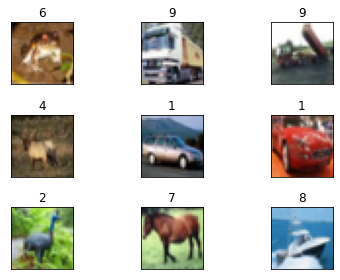

In [0]:
# plot some images
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.title(full_train_label[i])
    fig = plt.imshow(datx[i])
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
plt.tight_layout();

# Dimensionality Reduction - Principal Component Analysis

In [0]:
# PCA
scaled = StandardScaler().fit_transform(train_data)
pca =  PCA(n_components = 0.8, whiten=True, random_state=0).fit(scaled)

In [0]:
print(np.sum(pca.explained_variance_ratio_)) # 0.8986370641398359
print(pca.n_components_)

0.8003071525770684
34


In [0]:
pca_scaled = make_pipeline(StandardScaler(), PCA())
tic = timeit.default_timer()
pca_scaled.fit(train_data, train_label)
toc = timeit.default_timer()
print(f"time elapsed: {timedelta(seconds=toc-tic)}")
pca = pca_scaled.named_steps['pca']

time elapsed: 0:00:51.603833


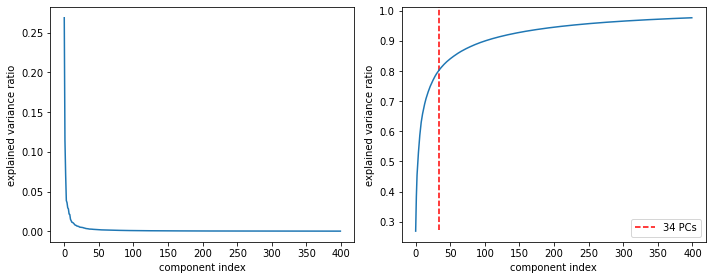

In [0]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(pca.explained_variance_ratio_[:400])
plt.axvline(34, 0.05, 1, label='34 PCs', c='r', ls='--')
axes[1].plot(np.cumsum(pca.explained_variance_ratio_[:400]))
for ax in axes:
    ax.set_xlabel("component index")
    ax.set_ylabel("explained variance ratio")
plt.legend()
plt.tight_layout()
plt.savefig("pca.png")

In [0]:
# Dimensionality Reduction - PCA
pca_scaled = make_pipeline(StandardScaler(), 
                           PCA(n_components = 0.8, whiten=True, random_state=0))
tic = timeit.default_timer()
X_train_pca = pca_scaled.fit_transform(train_data)
X_val_pca = pca_scaled.transform(val_data)
toc = timeit.default_timer()
print(f"time elapsed:              {timedelta(seconds=toc-tic)}")
print(f"PCA train data shape:      {X_train_pca.shape}")
print(f"PCA validation data shape: {X_val_pca.shape}")

time elapsed:              0:00:51.930381
PCA train data shape:      (35000, 34)
PCA validation data shape: (15000, 34)


# Dimensionality Reduction - Histogram of Oriented Gradients

In [0]:
# Histogram of Oriented Gradients
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure

def extract_hog(data):
    fd_array = np.empty(shape=(len(data), 3780), dtype='float')
    for i in range(len(data)):
        img = data[i]
        resized_img = resize(img, (128, 64))
        fd = hog(resized_img, orientations=9, pixels_per_cell=(8,8), 
                 cells_per_block=(2,2), visualize=False, multichannel=True, 
                 block_norm='L2-Hys')
        fd_array[i] = fd
    return fd_array

In [0]:
tic = timeit.default_timer()
full_train_data_hog = extract_hog(training_data)
test_data_hog = extract_hog(testing_data)
toc = timeit.default_timer()
print(f"time elapsed: {timedelta(seconds=toc-tic)}")

time elapsed: 0:08:04.094953


In [0]:
# Training and Validation Set Split
train_data_hg, val_data_hg, train_label, val_label = train_test_split(
    full_train_data_hog, full_train_label, test_size = 0.3,
    stratify = full_train_label, random_state = 40)
print(f'Train data:       X = {train_data_hg.shape}, y = {train_label.shape}')
print(f'Validation data:  X = {val_data_hg.shape}, y = {val_label.shape}')

Train data:       X = (35000, 3780), y = (35000,)
Validation data:  X = (15000, 3780), y = (15000,)


In [0]:
# Dimensionality Reduction - PCA
pca_scaled2 = make_pipeline(StandardScaler(), 
                           PCA(n_components = 0.8, whiten=True, random_state=0))
tic = timeit.default_timer()
X_train_hg = pca_scaled2.fit_transform(train_data_hg)
X_val_hg = pca_scaled2.transform(val_data_hg)
toc = timeit.default_timer()
print(f"time elapsed:              {timedelta(seconds=toc-tic)}")
print(f"PCA train data shape:      {X_train_hg.shape}")
print(f"PCA validation data shape: {X_val_hg.shape}")

time elapsed:              0:01:21.148698
PCA train data shape:      (35000, 469)
PCA validation data shape: (15000, 469)


# Classification

### Naive Bayes

##### Without HOG

In [0]:
%%timeit
gnb = GaussianNB()
gnb.fit(X_train_pca, train_label)

100 loops, best of 3: 16.5 ms per loop


In [0]:
gnb = GaussianNB()
gnb.fit(X_train_pca, train_label)
toc = timeit.default_timer()
print(f"Train accuracy: {gnb.score(X_train_pca, train_label)}") # 0.3435764705882353
print(f"Test accuracy:  {gnb.score(X_val_pca, val_label)}")     # 0.33413333333333334

Train accuracy: 0.37102857142857143
Test accuracy:  0.3702666666666667


In [0]:
# Save model file with pickle
nb_pickle = "Pickle_NaiveBayes.pkl"  

with open(nb_pickle, 'wb') as file:  
    pickle.dump(gnb, file)

In [0]:
# Load model from file with pickle
with open(nb_pickle, 'rb') as file:  
    pickled_gnb = pickle.load(file)

pickled_gnb

GaussianNB(priors=None, var_smoothing=1e-09)

##### With HOG

In [0]:
%%timeit
gnb_h = GaussianNB()
gnb_h.fit(X_train_hg, train_label)

1 loop, best of 3: 292 ms per loop


In [0]:
gnb_h = GaussianNB()
gnb_h.fit(X_train_hg, train_label)
print(f"Train accuracy: {gnb_h.score(X_train_hg, train_label)}") # 0.11195294117647059
print(f"Test accuracy:  {gnb_h.score(X_val_hg, val_label)}")     # 0.1104

Train accuracy: 0.5090571428571429
Test accuracy:  0.4829333333333333


In [0]:
# Save model file with pickle
nb_pickle_h = "Pickle_NaiveBayes_h.pkl"  

with open(nb_pickle_h, 'wb') as file:  
    pickle.dump(gnb_h, file)

In [0]:
# Load model from file with pickle
with open(nb_pickle_h, 'rb') as file:  
    pickled_gnb_h = pickle.load(file)

pickled_gnb_h

GaussianNB(priors=None, var_smoothing=1e-09)

### KNN

##### Without HOG

In [0]:
%%timeit
knn_mod = KNeighborsClassifier(n_neighbors=1)
knn_mod.fit(X_train_pca, train_label)

10 loops, best of 3: 168 ms per loop


In [0]:
knn_mod = KNeighborsClassifier(n_neighbors=1)
knn_mod.fit(X_train_pca, train_label)
print(f"Train accuracy: {knn_mod.score(X_train_pca, train_label)}") # 1.0
print(f"Test accuracy:  {knn_mod.score(X_val_pca, val_label):.4f}") # 0.3251

Train accuracy: 1.0
Test accuracy:  0.3878


In [0]:
# Save model file with pickle
knn_pickle = "Pickle_KNN.pkl"  

with open(knn_pickle, 'wb') as file:  
    pickle.dump(knn_mod, file)

In [0]:
# Load model from file with pickle
with open(knn_pickle, 'rb') as file:  
    pickled_knn = pickle.load(file)

pickled_knn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

##### With HOG

In [0]:
%%timeit
knn_mod_h = KNeighborsClassifier(n_neighbors=1)
knn_mod_h.fit(X_train_hg, train_label)

1 loop, best of 3: 3.15 s per loop


In [0]:
knn_mod_h = KNeighborsClassifier(n_neighbors=1)
knn_mod_h.fit(X_train_hg, train_label)
print(f"Train accuracy: {knn_mod_h.score(X_train_hg, train_label)}") # 1.0
print(f"Test accuracy:  {knn_mod_h.score(X_val_hg, val_label):.4f}") # 0.1719

Train accuracy: 1.0
Test accuracy:  0.1557


In [0]:
# Save model file with pickle
knn_pickle_h = "Pickle_KNN_h.pkl"  

with open(knn_pickle_h, 'wb') as file:  
    pickle.dump(knn_mod_h, file)

In [0]:
# Load model from file with pickle
with open(knn_pickle_h, 'rb') as file:  
    pickled_knn_h = pickle.load(file)

pickled_knn_h

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

### Logistic Regression

##### Without HOG

In [0]:
%%timeit
logreg = LogisticRegression(C=0.1)
logreg.fit(X_train_pca, train_label)

1 loop, best of 3: 836 ms per loop


In [0]:
logreg = LogisticRegression(C=0.1)
logreg.fit(X_train_pca, train_label)
print(f"Train accuracy: {logreg.score(X_train_pca, train_label)}") # 0.40489411764705885
print(f"Test accuracy:  {logreg.score(X_val_pca, val_label):.4f}") # 0.3965

Train accuracy: 0.37185714285714283
Test accuracy:  0.3715


In [0]:
# Save model file with pickle
logreg_pickle = "Pickle_LR.pkl"  

with open(logreg_pickle, 'wb') as file:  
    pickle.dump(logreg, file)

In [0]:
# Load model from file with pickle
with open(logreg_pickle, 'rb') as file:  
    pickled_logreg = pickle.load(file)

pickled_logreg

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

##### With HOG

In [0]:
%%timeit
logreg_h = LogisticRegression(C=0.1, solver='sag')
logreg_h.fit(X_train_hg, train_label)

1 loop, best of 3: 31.9 s per loop


In [0]:
logreg_h = LogisticRegression(C=0.1, solver='sag')
logreg_h.fit(X_train_hg, train_label)
print(f"Train accuracy: {logreg_h.score(X_train_hg, train_label)}") # 0.2256
print(f"Test accuracy:  {logreg_h.score(X_val_hg, val_label):.4f}") # 0.2272

Train accuracy: 0.5832571428571428
Test accuracy:  0.5430


In [0]:
# Save model file with pickle
logreg_pickle_h = "Pickle_LR_h.pkl"  

with open(logreg_pickle_h, 'wb') as file:  
    pickle.dump(logreg_h, file)

In [0]:
# Load model from file with pickle
with open(logreg_pickle_h, 'rb') as file:  
    pickled_logreg_h = pickle.load(file)

pickled_logreg_h

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

### Random Forest

##### Without HOG

In [0]:
%%timeit
rf = RandomForestClassifier()
rf.fit(X_train_pca, train_label)

1 loop, best of 3: 26 s per loop


In [0]:
rf = RandomForestClassifier()
rf.fit(X_train_pca, train_label)
print(f"Train accuracy: {rf.score(X_train_pca, train_label)}") # 1.0
print(f"Test accuracy:  {rf.score(X_val_pca, val_label):.4f}") # 0.4647

Train accuracy: 1.0
Test accuracy:  0.4647


In [0]:
# Save model file with pickle
rf_pickle = "Pickle_RF.pkl"  

with open(rf_pickle, 'wb') as file:  
    pickle.dump(rf, file)

In [0]:
# Load model from file with pickle
with open(rf_pickle, 'rb') as file:  
    pickled_rf = pickle.load(file)

pickled_rf

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

##### With HOG

In [0]:
%%timeit
rf_h = RandomForestClassifier()
rf_h.fit(X_train_hg, train_label)

1 loop, best of 3: 1min 50s per loop


In [0]:
rf_h = RandomForestClassifier()
rf_h.fit(X_train_hg, train_label)
print(f"Train accuracy: {rf_h.score(X_train_hg, train_label)}") # 1.0
print(f"Test accuracy:  {rf_h.score(X_val_hg, val_label):.4f}") # 0.4339

Train accuracy: 1.0
Test accuracy:  0.4339


In [0]:
# Save model file with pickle
rf_pickle_h = "Pickle_RF_h.pkl"  

with open(rf_pickle_h, 'wb') as file:  
    pickle.dump(rf_h, file)

In [0]:
# Load model from file with pickle
with open(rf_pickle_h, 'rb') as file:  
    pickled_rf_h = pickle.load(file)

pickled_rf_h

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

### Gradient Boosting

##### Without HOG

In [0]:
%%timeit
xgb = HistGradientBoostingClassifier()
xgb.fit(X_train_pca, train_label)

1 loop, best of 3: 11.3 s per loop


In [0]:
xgb = HistGradientBoostingClassifier()
xgb.fit(X_train_pca, train_label)
print(f"Train accuracy: {xgb.score(X_train_pca, train_label)}") # 0.8060
print(f"Test accuracy:  {xgb.score(X_val_pca, val_label):.4f}") # 0.4803

Train accuracy: 0.8060285714285714
Test accuracy:  0.4803


In [0]:
# Save model file with pickle
xgb_pickle = "Pickle_XGB.pkl"  

with open(xgb_pickle, 'wb') as file:  
    pickle.dump(xgb, file)

In [0]:
# Load model from file with pickle
with open(xgb_pickle, 'rb') as file:  
    pickled_xgb = pickle.load(file)

pickled_xgb

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

##### With HOG (Crashes due to too many features)

In [0]:
%%timeit
xgb_h = HistGradientBoostingClassifier()
xgb_h.fit(X_train_hg, train_label)

In [0]:
xgb_h = HistGradientBoostingClassifier()
xgb_h.fit(X_train_hg, train_label)
print(f"Train accuracy: {xgb_h.score(X_train_hg, train_label)}") # 0.2256
print(f"Test accuracy:  {xgb_h.score(X_val_hg, val_label):.4f}") # 0.2272

In [0]:
# Save model file with pickle
xgb_pickle_h = "Pickle_XGB_h.pkl"  

with open(xgb_pickle_h, 'wb') as file:  
    pickle.dump(xgb_h, file)

In [0]:
# Load model from file with pickle
with open(xgb_pickle_h, 'rb') as file:  
    pickled_xgb_h = pickle.load(file)

pickled_xgb_h

### SVM

##### Without HOG

In [0]:
%%timeit
svm = SVC(C=10)
svm.fit(X_train_pca, train_label)

1 loop, best of 3: 2min 43s per loop


In [0]:
svm = SVC(C=10)
svm.fit(X_train_pca, train_label)
print(f"Train accuracy: {svm.score(X_train_pca, train_label)}") # 0.9298
print(f"Test accuracy:  {svm.score(X_val_pca, val_label):.4f}") # 0.5183

Train accuracy: 0.9298
Test accuracy:  0.5183


In [0]:
# Save model file with pickle
svm_pickle = "Pickle_SVM.pkl"  

with open(svm_pickle, 'wb') as file:  
    pickle.dump(svm, file)

In [0]:
# Load model from file with pickle
with open(svm_pickle, 'rb') as file:  
    pickled_svm = pickle.load(file)

pickled_svm

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

##### With HOG (Crashes due to too many features)

In [0]:
%%timeit
svm_h = SVC(C=10)
svm_h.fit(X_train_hg, train_label)

1 loop, best of 3: 1min 50s per loop


In [0]:
svm_h = SVC(C=10)
svm_h.fit(X_train_hg, train_label)
print(f"Train accuracy: {svm_h.score(X_train_hg, train_label)}") # 0.2256
print(f"Test accuracy:  {svm_h.score(X_val_hg, val_label):.4f}") # 0.2272

Train accuracy: 1.0
Test accuracy:  0.4350


In [0]:
# Save model file with pickle
svm_pickle_h = "Pickle_RF_h.pkl"  

with open(svm_pickle_h, 'wb') as file:  
    pickle.dump(svm_h, file)

In [0]:
# Load model from file with pickle
with open(svm_pickle_h, 'rb') as file:  
    pickled_svm_h = pickle.load(file)

pickled_svm_h

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

# Metrics

In [0]:
# Model predictions
pred01 = gnb.predict(X_val_pca)        # Naive Bayes without HOG
pred02 = gnb_h.predict(X_val_hg)       # Naive Bayes with HOG
pred03 = knn_mod.predict(X_val_pca)    # KNN without HOG
pred04 = knn_mod_h.predict(X_val_hg)   # KNN Bayes with HOG
pred05 = logreg.predict(X_val_pca)     # Logistic Regression without HOG
pred06 = logreg_h.predict(X_val_hg)    # Logistic Regression with HOG
pred07 = rf.predict(X_val_pca)         # Random Forest without HOG
pred08 = rf_h.predict(X_val_hg)        # Random Forest Regression with HOG
pred09 = xgb.predict(X_val_pca)        # SVM without HOG
pred10 = svm.predict(X_val_pca)        # SVM without HOG

In [0]:
# Classification report
for pred in [pred01, pred02, pred03, pred04, pred05, 
             pred06, pred07, pred08, pred09, pred10]:
    print(classification_report(val_label, pred))

              precision    recall  f1-score   support

           0       0.44      0.39      0.41      1500
           1       0.40      0.38      0.39      1500
           2       0.26      0.14      0.18      1500
           3       0.29      0.23      0.26      1500
           4       0.29      0.42      0.34      1500
           5       0.38      0.30      0.34      1500
           6       0.34      0.58      0.43      1500
           7       0.42      0.31      0.36      1500
           8       0.48      0.46      0.47      1500
           9       0.41      0.49      0.45      1500

    accuracy                           0.37     15000
   macro avg       0.37      0.37      0.36     15000
weighted avg       0.37      0.37      0.36     15000

              precision    recall  f1-score   support

           0       0.46      0.62      0.53      1500
           1       0.67      0.62      0.64      1500
           2       0.37      0.27      0.31      1500
           3       0.34 